In [1]:
"""
assumption
* source treats target, i.e. drug treats disease, so it is directional 

feature engineering ideas
* description in node feature

Things to do
* compare with the embeddings given
* how to understand feature importance for graphs
* if there is leakage
"""

'\nassumption\n* source treats target, i.e. drug treats disease, so it is directional \n\nfeature engineering ideas\n* description in node feature\n\nThings to do\n* compare with the embeddings given\n* how to understand feature importance for graphs\n* if there is leakage\n'

In [22]:
from collections import defaultdict
import pandas as pd
import dgl
import dgl.nn as dglnn
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
ground_truth_path = '/Users/jefferykwan/Downloads/Ground Truth.csv'
nodes_path = '/Users/jefferykwan/Downloads/Nodes.csv'
edges_path = '/Users/jefferykwan/Downloads/Edges.csv'

In [4]:
ground_truth_df = pd.read_csv(ground_truth_path)
edges_df = pd.read_csv(edges_path)
nodes_df = pd.read_csv(nodes_path)

rename_index = {'Unnamed: 0': 'index'}

ground_truth_df = ground_truth_df.rename(rename_index, axis=1)
edges_df = edges_df.rename(rename_index, axis=1)
nodes_df = nodes_df.rename(rename_index, axis=1)

Class breakdown 
 y
0    16811
1    11557
Name: count, dtype: int64 

Count from unique source target pairs 
 source                        target       
CHEBI:35457                   MESH:D006984     1
CHEMBL.COMPOUND:CHEMBL314854  MONDO:0003005    1
CHEMBL.COMPOUND:CHEMBL315985  MONDO:0001386    1
CHEMBL.COMPOUND:CHEMBL315795  MONDO:0013600    1
                              MONDO:0002125    1
                                              ..
CHEMBL.COMPOUND:CHEMBL126     MONDO:0005249    1
                              MONDO:0005244    1
                              MONDO:0005230    1
                              MONDO:0005229    1
VANDF:4021915                 MONDO:0001830    1
Name: count, Length: 28368, dtype: int64 



<Axes: title={'center': 'Disease success rate of of being treated in ground truth'}, xlabel='target'>

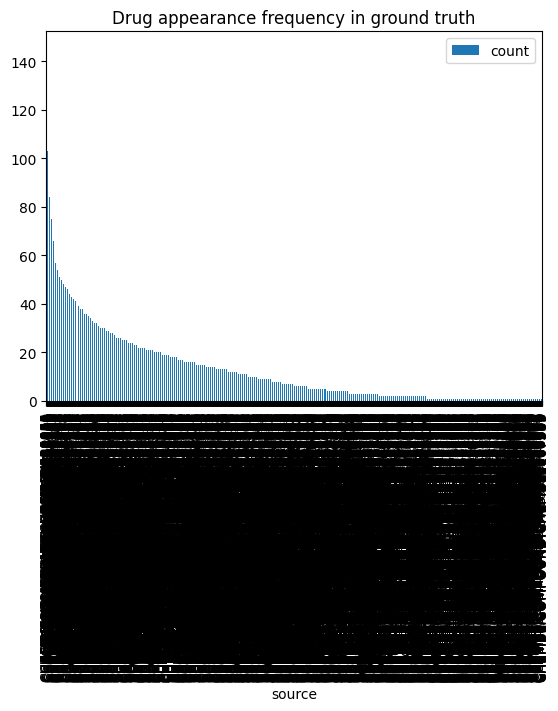

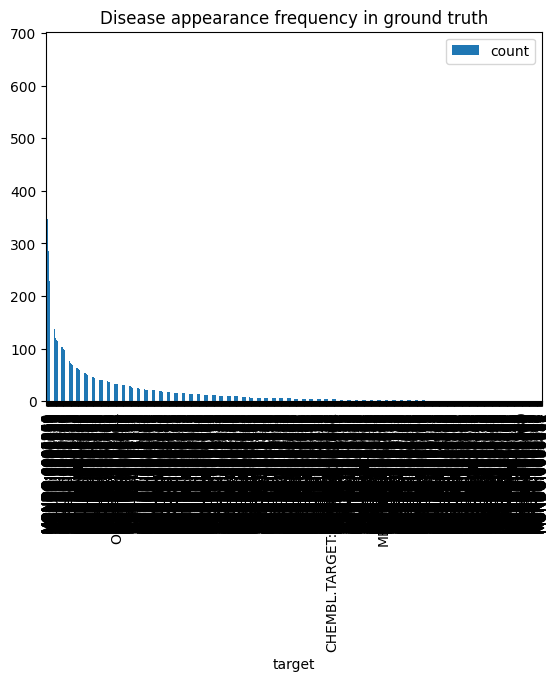

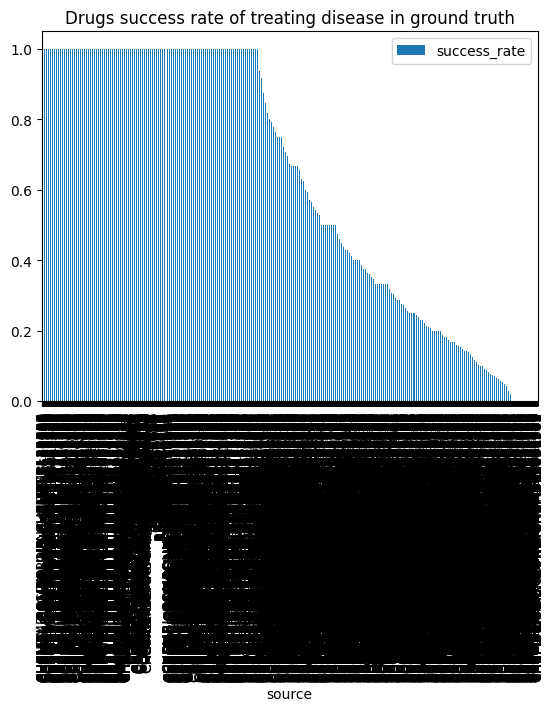

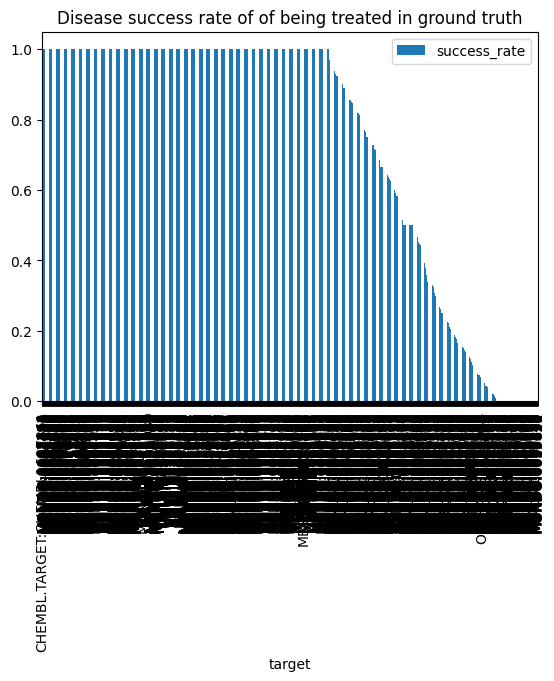

In [5]:
""" 
Understanding ground truth file
"""

# High level class breakdown, pretty balanced
print('Class breakdown \n', ground_truth_df['y'].value_counts(dropna=False), '\n')

# Double checking there are no duplicates in our targets - i.e. we only have unique drug disease pairs.
# You can also see here that there are drugs that target multiple diseases.
# I would assume the reverse is true - diseases can be treated by multiple drugs.
print('Count from unique source target pairs \n', ground_truth_df[['source', 'target']].value_counts(dropna=False), '\n')

# Looking at the drugs and disease separately (not drug disease pairs), seems like some drugs and diseases have much more connections than others.
# Ignore the x-axis labels here, names are long and clustered and haven't prioritised prettifying it, 
# but they are just the drug names.
gt_drugs_cnt = ground_truth_df['source'].value_counts(dropna=False).reset_index()
gt_drugs_cnt.plot.bar(x='source', y='count', title='Drug appearance frequency in ground truth')

gt_disease_cnt = ground_truth_df['target'].value_counts(dropna=False).reset_index()
gt_disease_cnt.plot.bar(x='target', y='count', title='Disease appearance frequency in ground truth')

# Then looking at success rate for drugs and disease separately, but this might be affected by where we sample the pos/neg class examples
gt_source_success_rate_df = ground_truth_df.groupby(['source'])['y'].agg(['sum', 'count']).reset_index()
gt_source_success_rate_df['success_rate'] = gt_source_success_rate_df['sum'] / gt_source_success_rate_df['count']

gt_source_success_rate_df = gt_source_success_rate_df.sort_values('success_rate', ascending=False)
gt_source_success_rate_df.plot.bar(x='source', y='success_rate', title='Drugs success rate of treating disease in ground truth')

gt_target_success_rate_df = ground_truth_df.groupby(['target'])['y'].agg(['sum', 'count']).reset_index()
gt_target_success_rate_df['success_rate'] = gt_target_success_rate_df['sum'] / gt_target_success_rate_df['count']

gt_target_success_rate_df = gt_target_success_rate_df.sort_values('success_rate', ascending=False)
gt_target_success_rate_df.plot.bar(x='target', y='success_rate', title='Disease success rate of of being treated in ground truth')

In [6]:
""" 
Understanding edges
"""

# when looking at a few rows of the edges_df, 3 main column types were focused (source_type/destination_type/relationship_type), 
# and noticed there were 2 columns per type that seemed to be duplicates
print('Predicate vs. Type match % \n', (edges_df['predicate'] == (edges_df['type'])).sum() / edges_df.shape[0], '\n')
print('Subject vs. start_id match % \n', (edges_df['subject'] == (edges_df['start_id'])).sum() / edges_df.shape[0], '\n')
print('object vs. end_id match % \n', (edges_df['object'] == (edges_df['end_id'])).sum() / edges_df.shape[0], '\n')

# there was only one row that didn't match as the type/start_id/end_id was null, 
# therefore am going to use subject->predicate->object
print('Rows not matching between subject/start_id, predicate/type, object/end_id:')
display(edges_df[edges_df['predicate'] != edges_df['type']])

# checking that subject/object in edge file matches source/target in ground truth file - all gt nodes are covered, 
# but not necessarily in expected relationships
print('Source from ground truth missing in edge file: \n', set(ground_truth_df['source']) - (set(edges_df['subject']) | set(edges_df['object'])))
print('Source from ground truth appearing in edge subject: \n', len(set(ground_truth_df['source']) & set(edges_df['subject'])))
print('Source from ground truth missing from edge subject: \n', len(set(ground_truth_df['source']) - set(edges_df['subject'])))
print('Target from ground truth missing in edge file: \n', set(ground_truth_df['target']) - (set(edges_df['subject']) | set(edges_df['object'])))
print('Target from ground truth appearing in edge object: \n', len(set(ground_truth_df['target']) & set(edges_df['object'])))
print('Target from ground truth missing from edge object: \n', len(set(ground_truth_df['target']) - set(edges_df['object'])), '\n')

# checking if subject/object has more than one edge type
print('Check if the same subject/object can have different relationships \n', edges_df[['subject', 'object']].value_counts(dropna=False), '\n')

# check what edge types are the ground truths mapped to
# we can see majority of true ground truths (source -> target when y == 1) don't actually map to the edge file (subject -> object)
# when it matches, the majority is biolink:treats, but we can see biolink:prevents and biolink:disrupts as well
print('When ground truth is 1, what edge types is it mapped to: \n', ground_truth_df[ground_truth_df['y'] == 1][['source', 'target']].merge(edges_df, how='left', left_on=['source', 'target'], right_on=['subject', 'object'])['type'].value_counts(dropna=False))

Predicate vs. Type match % 
 0.9999945581192861 

Subject vs. start_id match % 
 0.9999945581192861 

object vs. end_id match % 
 0.9999945581192861 

Rows not matching between subject/start_id, predicate/type, object/end_id:


,index,subject,object,predicate,knowledge_source,publications,publications_info,type,start_id,end_id
163299,163299,CHEBI:32952,UMLS:C0220806,biolink:physically_interacts_with,infores:semmeddb,PMID:15341845ǂPMID:16261236ǂPMID:17105178ǂPMID...,"{'PMID:26511979': {'publication date': '2015',...",NaN,NaN,NaN


Source from ground truth missing in edge file: 
 set()
Source from ground truth appearing in edge subject: 
 2054
Source from ground truth missing from edge subject: 
 177
Target from ground truth missing in edge file: 
 set()
Target from ground truth appearing in edge object: 
 1339
Target from ground truth missing from edge object: 
 215 

Check if the same subject/object can have different relationships 
 subject                        object                    
FMA:6459                       FMA:287407                    2
ENSEMBL:ENST00000397152        UniProtKB:Q9NQG1              2
CHEMBL.COMPOUND:CHEMBL1201538  UniProtKB:P08069              2
MONDO:0015925                  MONDO:0014956                 2
MONDO:0001020                  MONDO:0030907                 2
                                                            ..
PR:Q68FQ8                      UniProtKB:Q9Y238              1
PR:Q68FR2                      UniProtKB:Q9UBW5              1
PR:Q68FS6                 

In [7]:
""" 
Understanding nodes
"""

# Check that nodes in nodes file and nodes in edges file match
print('Do the nodes in node file match the edge file:', (set(edges_df['subject']) | set(edges_df['object'])) == set(nodes_df['id']), '\n')

# Check if nodes in ground truth are covered by the nodes file
print('Are there any missing nodes from the ground truth that is not covered by nodes file:', (set(ground_truth_df['source']) | set(ground_truth_df['target'])) - set(nodes_df['id']), '\n')

# Check unique values of each node feature
print('Unique values of each node feature: \n', nodes_df.nunique(), '\n')

# Some of the features are useless - iri, equivalent_curies.
# Most features may not be directly usable as there is too many unique values - name, all_names, publications, description,
# but they can be potentially useful if some time are spent on trying to cluster / create groupings.
# Description looks like a high potential feature for further feature engineering,
# but for now, will only focus on features that seem usable directly
selected_node_features = [
    # 'category', # this looks more like a node type than attribute
    'label', # seems related to category
]

# Check the node types of the ground truth nodes.
# Seems like gt source node types are small molecule or drugs, and target node types are disease and/or phenotypic feature.
print('Node type of the source nodes in ground truth: \n', ground_truth_df[['source']].merge(nodes_df[['id', 'category']], how='left', left_on=['source'], right_on=['id'])['category'].value_counts(dropna=False), '\n')
print('Node type of the source nodes in ground truth: \n', ground_truth_df[['target']].merge(nodes_df[['id', 'category']], how='left', left_on=['target'], right_on=['id'])['category'].value_counts(dropna=False), '\n')

Do the nodes in node file match the edge file: True 

Are there any missing nodes from the ground truth that is not covered by nodes file: set() 

Unique values of each node feature: 
 index                170009
id                   170009
name                 157513
category                 32
all_names            157576
all_categories         1106
iri                  170009
description           59442
equivalent_curies    170009
publications          24010
label                   433
dtype: int64 

Node type of the source nodes in ground truth: 
 category
biolink:SmallMolecule    27238
biolink:Drug              1130
Name: count, dtype: int64 

Node type of the source nodes in ground truth: 
 category
biolink:Disease                       27509
biolink:PhenotypicFeature               447
biolink:DiseaseOrPhenotypicFeature      412
Name: count, dtype: int64 



In [8]:
""" 
Merging edge data with nodes, and appending ground truth, to create final dataframe pre-graph build.
It seems like our graph data only contains a portion of the ground truth relationships.
Also, similar node/edge types are grouped based on the ground truths file,
for example, edge types treats/prevents/disrupts are all 1 in the ground truths file
"""

graph_df = edges_df.merge(nodes_df[['id', 'category', 'label']].add_suffix('_subject'), how='left', left_on='subject', right_on='id_subject')
graph_df = graph_df.merge(nodes_df[['id', 'category', 'label']].add_suffix('_object'), how='left', left_on='object', right_on='id_object')
graph_df = graph_df.merge(ground_truth_df[['source', 'target', 'y']], how='left', left_on=['subject', 'object'], right_on=['source','target'])

# Interesting, class is now heavier weighted towards positive than negative.
print(graph_df['y'].value_counts(dropna=False))

# grouping similar node/edge types based on ground truths file
graph_grouped_df = graph_df.copy()
src_type_group = ['biolink:SmallMolecule', 'biolink:Drug']
edge_type_group = ['biolink:treats', 'biolink:prevents', 'biolink:disrupts']
dst_type_group = ['biolink:Disease', 'biolink:DiseaseOrPhenotypicFeature', 'biolink:PhenotypicFeature']
graph_grouped_df['category_subject'] = np.where(graph_grouped_df['category_subject'].isin(src_type_group), 'biolink:Drug', graph_grouped_df['category_subject'])
graph_grouped_df['predicate'] = np.where(graph_grouped_df['predicate'].isin(edge_type_group), 'biolink:treats', graph_grouped_df['predicate'])
graph_grouped_df['category_object'] = np.where(graph_grouped_df['category_object'].isin(dst_type_group), 'biolink:Disease', graph_grouped_df['category_object'])

# Create node ids for generating graph, and sorting the nodes.
# This creates a unique node type, node id combination from the union of subject and object
unique_node_type_id = set([tuple(i) for i in np.vstack((graph_grouped_df[['category_subject', 'subject']].values, graph_grouped_df[['category_object', 'object']].values)).tolist()])
node_id_mapper = defaultdict(list)

for node_type_id in list(unique_node_type_id):
    node_id_mapper[node_type_id[0]].append(node_type_id[1])

for node_type in node_id_mapper.keys():
    node_id_mapper[node_type] = {node_id: idx for idx, node_id in enumerate(node_id_mapper[node_type])}

graph_grouped_df['subject_id'] = [node_id_map[node_id] for node_id, node_id_map in zip(graph_grouped_df['subject'], graph_grouped_df['category_subject'].map(node_id_mapper))]
graph_grouped_df['object_id'] = [node_id_map[node_id] for node_id, node_id_map in zip(graph_grouped_df['object'], graph_grouped_df['category_object'].map(node_id_mapper))]
graph_grouped_df = graph_grouped_df.sort_values(['subject_id', 'object_id'])



y
NaN    183511
1.0       128
0.0       121
Name: count, dtype: int64


In [9]:
""" 
Heterograph creation, using the edge file structure:
source node type <- category from the node file
edge type <- predicate from the edge file
destination node type <- category from the node file
source/destination node ids <- index/id per node id per node type
node features <- all node types sharing the  'label' feature from node file
"""

# Create the hetero graph structure in the form of (source node type, edge type, destination node type): (src_ids, dst_ids)
hetero_graph_dict = defaultdict(list)

for edge_relationship in graph_grouped_df[['category_subject', 'predicate', 'category_object']].value_counts().reset_index().values:
    src_type = edge_relationship[0]
    edge_type = edge_relationship[1]
    dst_type = edge_relationship[2]
    
    edge_relationship_match = graph_grouped_df[(graph_grouped_df['category_subject'] == src_type) & (graph_grouped_df['predicate'] == edge_type) & (graph_grouped_df['category_object'] == dst_type)]
    for src_dst_ids in edge_relationship_match[['subject_id', 'object_id']].values:
        hetero_graph_dict[(src_type, edge_type, dst_type)].append((src_dst_ids[0], src_dst_ids[1]))

hetero_graph_structure = {edge_relationships: (torch.tensor(list(zip(*src_dst_ids))[0]), torch.tensor(list(zip(*src_dst_ids))[1])) for edge_relationships, src_dst_ids in hetero_graph_dict.items()}

# Generate hetero graph
hetero_graph = dgl.heterograph(hetero_graph_structure)

# Check if the created graph matches my expectations when doing EDA on the raw dataset
print('Unique node types count:', len(set(hetero_graph.ntypes)))
print('Unique edge types count:', len(set(hetero_graph.etypes)))
print('Unique edge relationship count:', len(set(hetero_graph.canonical_etypes)))
print(hetero_graph)

# adding the node features
node_to_label_mapper = {i[0]: i[1] for i in nodes_df[['id','label']].values}

labels = nodes_df['label'].value_counts().reset_index()['label'].to_list()
lb = LabelBinarizer()
lb.fit(labels)

for i in hetero_graph.ntypes:
    labels = [node_to_label_mapper[node_id] for node_id in node_id_mapper[i].keys()]

    encoded_labels = lb.transform(labels)
    hetero_graph.nodes[i].data['feature'] = torch.tensor(encoded_labels)

# Normally target distribution from random splitting broadly follows overall dataset.
# Checked here wasn't too different.
train_graph_df, test_graph_df = train_test_split(graph_grouped_df[~graph_grouped_df['y'].isna()], test_size=0.2, random_state=42)

Unique node types count: 32
Unique edge types count: 57
Unique edge relationship count: 1488
Graph(num_nodes={'biolink:AnatomicalEntity': 6477, 'biolink:Behavior': 101, 'biolink:BehavioralFeature': 6, 'biolink:BiologicalEntity': 739, 'biolink:BiologicalProcess': 292, 'biolink:BiologicalProcessOrActivity': 5, 'biolink:Cell': 313, 'biolink:CellLine': 17, 'biolink:CellularComponent': 587, 'biolink:ChemicalEntity': 3646, 'biolink:ChemicalMixture': 3, 'biolink:Disease': 9258, 'biolink:DiseaseOrPhenotypicFeature': 510, 'biolink:Drug': 18832, 'biolink:Food': 78, 'biolink:Gene': 3469, 'biolink:GeneFamily': 66, 'biolink:GrossAnatomicalStructure': 549, 'biolink:MolecularActivity': 15765, 'biolink:MolecularEntity': 6035, 'biolink:NoncodingRNAProduct': 2, 'biolink:NucleicAcidEntity': 738, 'biolink:OrganismTaxon': 26575, 'biolink:Pathway': 37593, 'biolink:PhenotypicFeature': 81, 'biolink:PhysiologicalProcess': 2777, 'biolink:Polypeptide': 1177, 'biolink:Protein': 17112, 'biolink:RNAProduct': 16, 'b

In [10]:
""" 
Model build, idea here is to keep the whole graph for maximum information to obtain node embeddings.
Then node embeddings are then used for optimising against link prediction.
Positive and negative edge type graphs come from successful joined ground truth src/dst pairs to the graph built using edge and node file,
which isn't that much.

One concern is whether exposing to the whole graph is introducing leakage, as might be exposed to the test set edge types
"""

def construct_negative_graph(graph, filter_graph, etype):
    neg_src = list(zip(*filter_graph[filter_graph['y'] == 0][['subject_id', 'object_id']].values))[0]
    neg_dst = list(zip(*filter_graph[filter_graph['y'] == 0][['subject_id', 'object_id']].values))[1]
    return dgl.heterograph(
        {etype: (neg_src, neg_dst)},
        num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})

def construct_positive_graph(graph, filter_graph, etype):
    pos_src = list(zip(*filter_graph[filter_graph['y'] == 1][['subject_id', 'object_id']].values))[0]
    pos_dst = list(zip(*filter_graph[filter_graph['y'] == 1][['subject_id', 'object_id']].values))[1]
    return dgl.heterograph(
        {etype: (pos_src, pos_dst)},
        num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})

class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()
        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroDotProductPredictor()
    def forward(self, g, pos_g, neg_g, x, etype):
        h = self.sage(g, x)
        return self.pred(pos_g, h, etype), self.pred(neg_g, h, etype)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels.unsqueeze(1))

# Training loss going down per epoch

node_features = {i: hetero_graph.nodes[i].data['feature'] for i in hetero_graph.ntypes}
model = Model(list(node_features.values())[0].shape[1], 100, len(hetero_graph.ntypes), hetero_graph.etypes)
opt = torch.optim.Adam(model.parameters())
for epoch in range(5):
    train_negative_graph = construct_negative_graph(hetero_graph, train_graph_df, ('biolink:Drug', 'biolink:treats', 'biolink:Disease'))
    train_positive_graph = construct_positive_graph(hetero_graph, train_graph_df, ('biolink:Drug', 'biolink:treats', 'biolink:Disease'))
    train_pos_score, train_neg_score = model(hetero_graph, train_positive_graph, train_negative_graph, node_features, ('biolink:Drug', 'biolink:treats', 'biolink:Disease'))
    loss = compute_loss(train_pos_score, train_neg_score)
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

0.6931471228599548
0.6845371127128601
0.6610307693481445
0.5810322761535645
0.5158958435058594


In [ ]:
test_negative_graph = construct_negative_graph(hetero_graph, test_graph_df, ('biolink:Drug', 'biolink:treats', 'biolink:Disease'))
test_positive_graph = construct_positive_graph(hetero_graph, test_graph_df, ('biolink:Drug', 'biolink:treats', 'biolink:Disease'))

h = model.sage(hetero_graph, node_features)

test_pos_score = model.pred(test_positive_graph, h, ('biolink:Drug', 'biolink:treats', 'biolink:Disease'))
test_neg_score = model.pred(test_negative_graph, h, ('biolink:Drug', 'biolink:treats', 'biolink:Disease'))

def create_output_df(test_pos_score, test_neg_score):

    pos_output_df = pd.DataFrame(torch.nn.functional.sigmoid(test_pos_score).detach().cpu().numpy(), columns=['Drug_treats_disease_pred'])
    pos_output_df['True_class'] = 1
    neg_output_df = pd.DataFrame(torch.nn.functional.sigmoid(test_neg_score).detach().cpu().numpy(), columns=['Drug_treats_disease_pred'])
    neg_output_df['True_class'] = 0
    output_df = pd.concat([pos_output_df, neg_output_df], ignore_index=True)

    return output_df

train_output_df = create_output_df(train_pos_score, train_neg_score)
test_output_df = create_output_df(test_pos_score, test_neg_score)

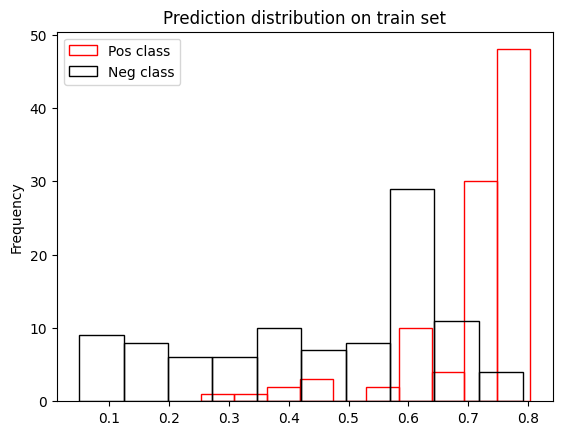

In [ ]:
train_output_df[train_output_df['True_class'] == 1]['Drug_treats_disease_pred'].plot.hist(title='Prediction distribution on train set', fill=False, edgecolor='red')
train_output_df[train_output_df['True_class'] == 0]['Drug_treats_disease_pred'].plot.hist(title='Prediction distribution on train set', fill=False)
plt.legend(['Pos class', 'Neg class'])

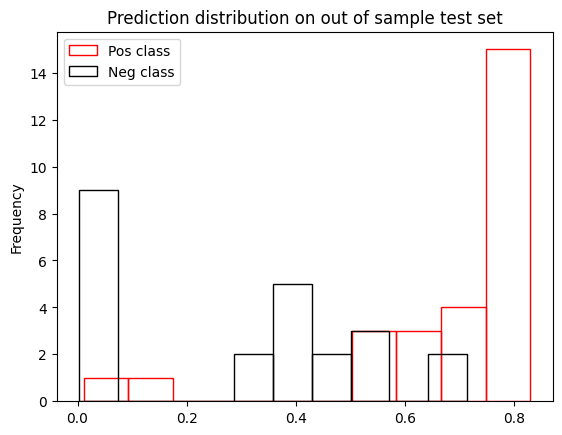

In [27]:
test_output_df[test_output_df['True_class'] == 1]['Drug_treats_disease_pred'].plot.hist(title='Prediction distribution on out of sample test set', fill=False, edgecolor='red')
test_output_df[test_output_df['True_class'] == 0]['Drug_treats_disease_pred'].plot.hist(title='Prediction distribution on out of sample test set', fill=False)
plt.legend(['Pos class', 'Neg class'])